In [9]:
# Imports
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Configuration
DATASET_DIR = 'dataset/GTSRB'  
TRAIN_CSV = os.path.join(DATASET_DIR, 'Train.csv')
TEST_CSV  = os.path.join(DATASET_DIR, 'Test.csv')
META_CSV  = os.path.join(DATASET_DIR, 'Meta.csv')
IMG_SIZE = (64, 64)
BATCH_SIZE = 64
NUM_CLASSES = 43
RANDOM_STATE = 42

In [ ]:
# --- Inspect CSVs and show random samples
# reads CSVs, prints headings and a few rows, and shows sample images with labels and ROI boxes.
train_df = pd.read_csv(TRAIN_CSV)
test_df  = pd.read_csv(TEST_CSV)

# Meta may or may not contain sign names. Handle both cases.
if os.path.exists(META_CSV):
    meta_df = pd.read_csv(META_CSV)
else:
    meta_df = pd.DataFrame(columns=['ClassId'])

print("Train.csv columns:", train_df.columns.tolist())
print("Test.csv columns:", test_df.columns.tolist())
print("Meta.csv columns:", meta_df.columns.tolist())

print('--- Train.csv sample ---')
print(train_df.head())
print('--- Test.csv sample ---')
print(test_df.head())
print('--- Meta.csv sample ---')
print(meta_df.head())
print('Number of training samples:', len(train_df))
print('Number of test samples:', len(test_df))
print('Number of unique classes:', train_df['ClassId'].nunique())

# Create a readable name mapping if Meta contains it; otherwise fallback to Class X
if 'SignName' in meta_df.columns:
    name_map = dict(zip(meta_df['ClassId'], meta_df['SignName']))
else:
    # Fallback: create simple names
    name_map = {cid: f"Class {cid}" for cid in sorted(train_df['ClassId'].unique())}


Train.csv columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
Test.csv columns: ['Width', 'Height', 'Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2', 'ClassId', 'Path']
Meta.csv columns: ['Path', 'ClassId', 'ShapeId', 'ColorId', 'SignId']
--- Train.csv sample ---
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId  \
0     27      26       5       5      22      20       20   
1     28      27       5       6      23      22       20   
2     29      26       6       5      24      21       20   
3     28      27       5       6      23      22       20   
4     28      26       5       5      23      21       20   

                             Path  
0  Train/20/00020_00000_00000.png  
1  Train/20/00020_00000_00001.png  
2  Train/20/00020_00000_00002.png  
3  Train/20/00020_00000_00003.png  
4  Train/20/00020_00000_00004.png  
--- Test.csv sample ---
   Width  Height  Roi.X1  Roi.Y1  Roi.X2  Roi.Y2  ClassId            Path
0     53      54       6     

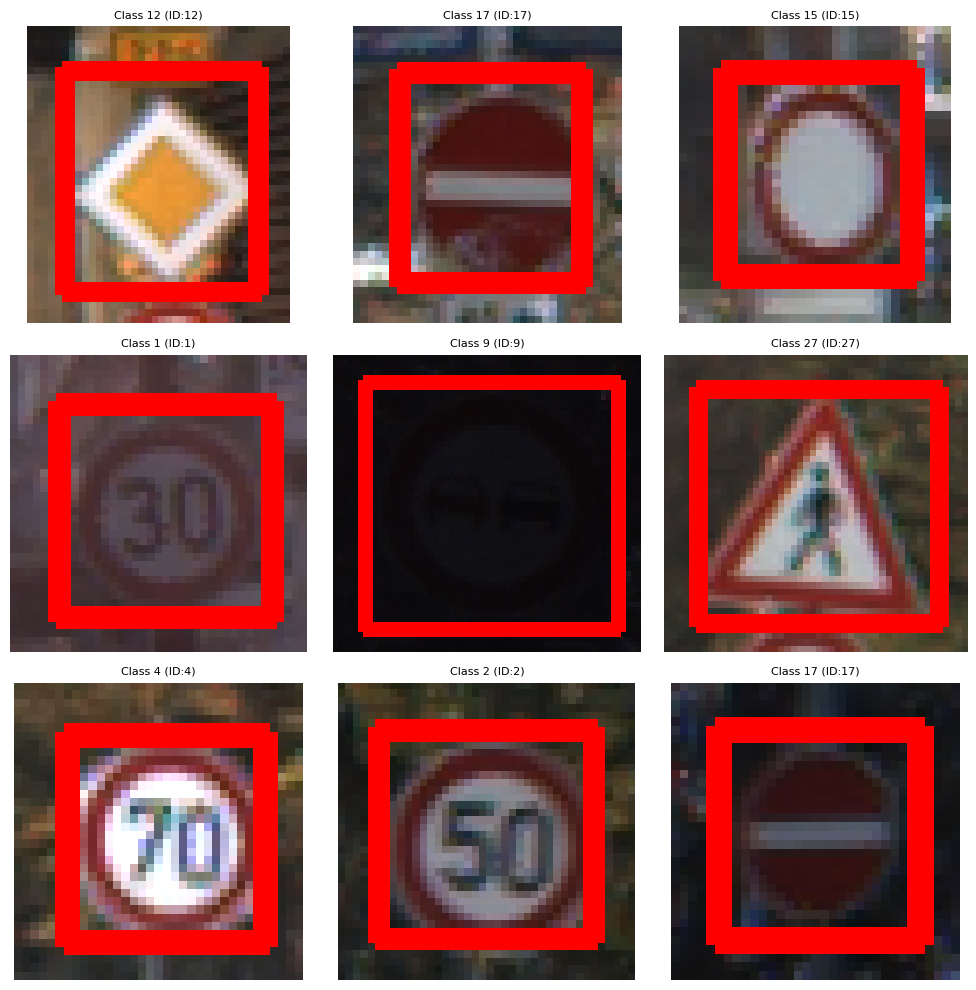

In [12]:
# Function to display random samples with ROI box and labels
import random

def show_random_samples(df, base_dir, n=9, figsize=(10,10), show_roi=True):
    samples = df.sample(n)
    cols = int(np.ceil(np.sqrt(n)))
    plt.figure(figsize=figsize)
    for i, (_, row) in enumerate(samples.iterrows()):
        img_path = os.path.join(base_dir, row['Path'])
        img = cv2.imread(img_path)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        # Draw ROI if available
        if show_roi and all(k in row.index for k in ['Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']):
            x1, y1, x2, y2 = int(row['Roi.X1']), int(row['Roi.Y1']), int(row['Roi.X2']), int(row['Roi.Y2'])
            cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)  # red box in RGB
        plt.subplot(cols, cols, i+1)
        plt.imshow(img)
        cid = int(row['ClassId'])
        plt.title(f"{name_map.get(cid, str(cid))} (ID:{cid})", fontsize=8)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Show 9 random training samples
show_random_samples(train_df, DATASET_DIR, n=9)

In [13]:
# CSV-based loader (keeps using ROI cropping option)

def load_data_from_csv(csv_path, base_dir, img_size=IMG_SIZE, use_roi=True):
    df = pd.read_csv(csv_path)
    images, labels = [], []
    for _, row in df.iterrows():
        img_path = os.path.join(base_dir, row['Path'])
        img = cv2.imread(img_path)
        if img is None:
            continue
        # Crop to ROI if requested and ROI columns exist
        if use_roi and all(k in row.index for k in ['Roi.X1', 'Roi.Y1', 'Roi.X2', 'Roi.Y2']):
            x1, y1, x2, y2 = int(row['Roi.X1']), int(row['Roi.Y1']), int(row['Roi.X2']), int(row['Roi.Y2'])
            # Ensure box within image
            h, w = img.shape[:2]
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(w-1, x2), min(h-1, y2)
            if x2 > x1 and y2 > y1:
                img = img[y1:y2, x1:x2]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        images.append(img)
        labels.append(row['ClassId'])
    return np.array(images, dtype=np.float32), np.array(labels, dtype=np.int64)

In [ ]:
# Load datasets
X_train, y_train = load_data_from_csv(TRAIN_CSV, DATASET_DIR, use_roi=True)
X_test, y_test   = load_data_from_csv(TEST_CSV, DATASET_DIR, use_roi=True)

print("Train:", X_train.shape, y_train.shape)
print("Test:", X_test.shape, y_test.shape)


# Preprocess
X_train = X_train / 255.0
X_test  = X_test / 255.0

# Split train into train/val
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.15, stratify=y_train, random_state=RANDOM_STATE
)


Train: (39209, 64, 64, 3) (39209,)
Test: (12630, 64, 64, 3) (12630,)


In [15]:
# Data augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False,
    fill_mode='nearest'
)
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
val_generator   = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

In [16]:
# Build models (fixed Input usage to avoid warning)

def build_custom_cnn(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=NUM_CLASSES):
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(32, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(64, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.Conv2D(64, (3,3), activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Conv2D(128, (3,3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2,2)),
        layers.Dropout(0.25),

        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model


def build_mobilenetv2(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=NUM_CLASSES):
    base = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base.trainable = False
    inputs = layers.Input(shape=input_shape)
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs * 255.0)
    x = base(x, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    return models.Model(inputs, outputs)


In [17]:
# Training helper (save in .keras format and plot history)

def compile_and_train(model, train_generator, val_generator, epochs=30, model_name='model'):
    model.compile(optimizer=optimizers.Adam(1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    ckpt = callbacks.ModelCheckpoint(f'{model_name}.keras', monitor='val_accuracy', save_best_only=True, verbose=1)
    early = callbacks.EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)

    history = model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=epochs,
                        callbacks=[ckpt, early])
    
# Plot training history
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return history


C:\Users\M4 Tech\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.1550 - loss: 3.8031
Epoch 1: val_accuracy improved from -inf to 0.37572, saving model to gtsrb_custom_cnn.keras
521/521 ━━━━━━━━━━━━━━━━━━━━ 149s 280ms/step - accuracy: 0.1552 - loss: 3.8017 - val_accuracy: 0.3757 - val_loss: 2.3575
Epoch 2/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.4561 - loss: 1.9337
Epoch 2: val_accuracy improved from 0.37572 to 0.76114, saving model to gtsrb_custom_cnn.keras
521/521 ━━━━━━━━━━━━━━━━━━━━ 144s 275ms/step - accuracy: 0.4562 - loss: 1.9334 - val_accuracy: 0.7611 - val_loss: 0.8667
Epoch 3/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.5975 - loss: 1.3489
Epoch 3: val_accuracy improved from 0.76114 to 0.86382, saving model to gtsrb_custom_cnn.keras
521/521 ━━━━━━━━━━━━━━━━━━━━ 154s 295ms/step - accuracy: 0.5976 - loss: 1.3487 - val_accuracy: 0.8638 - val_loss: 0.4980
Epoch 4/30
521/521 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.6971 - loss: 0.9898
Epo

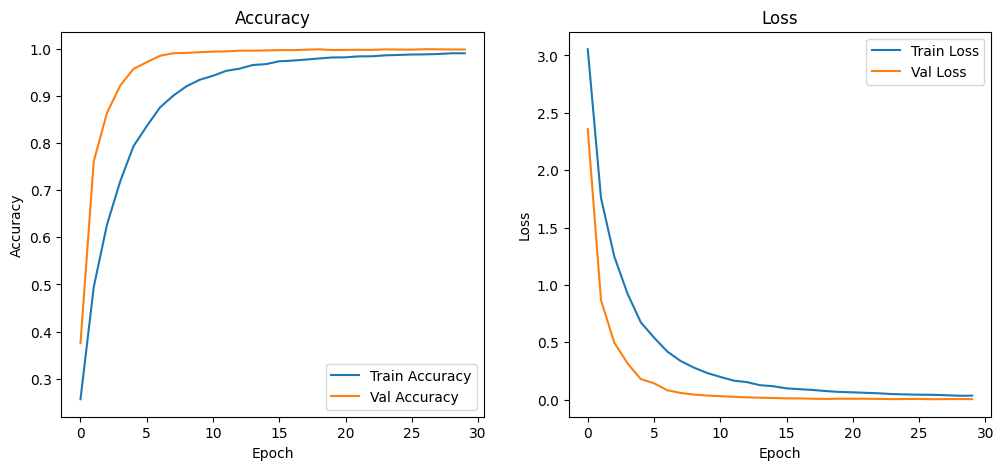

In [ ]:
# Train custom CNN
model = build_custom_cnn()
history = compile_and_train(model, train_generator, val_generator, epochs=30, model_name='gtsrb_custom_cnn')

In [19]:
# Evaluate on test set

# If test set images were loaded earlier, X_test is available
if 'X_test' in globals():
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    acc = np.mean(y_pred == y_test)
    print("Test accuracy:", acc)
else:
    print("X_test not found - make sure test CSV was loaded earlier")


395/395 ━━━━━━━━━━━━━━━━━━━━ 14s 35ms/step
Test accuracy: 0.979889152810768


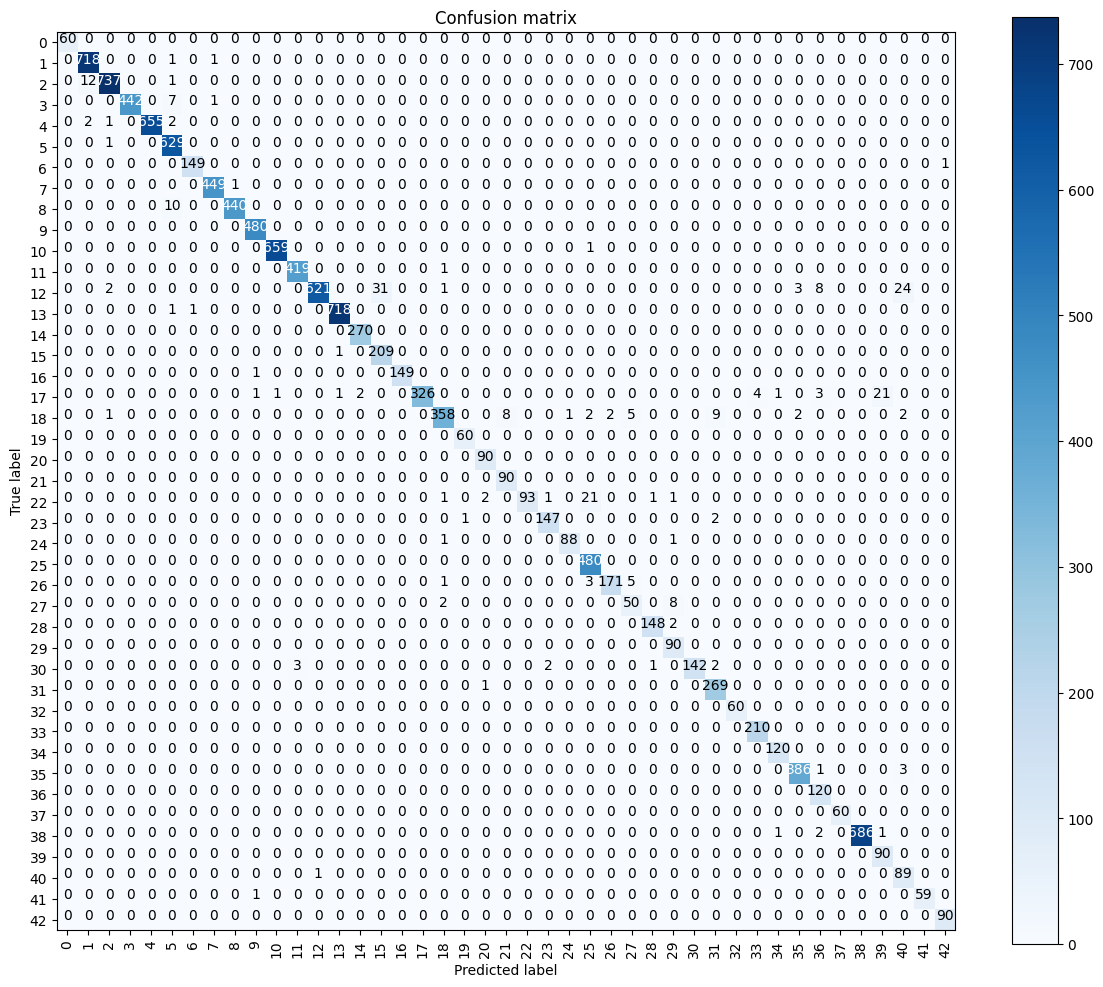

In [20]:
# Confusion matrix

def plot_confusion(y_true, y_pred, classes, figsize=(12,10)):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], 'd'),
                 horizontalalignment='center',
                 color='white' if cm[i, j] > thresh else 'black')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

# Plot confusion
if 'y_pred' in globals():
    plot_confusion(y_test, y_pred, classes=[str(i) for i in range(NUM_CLASSES)])
else:
    print('No predictions to plot in confusion matrix')



In [21]:
# Save the trained model in Keras v3 format
model.save("gtsrb_custom_cnn0.keras")

print("Model saved as gtsrb_custom_cnn0.keras")


Model saved as gtsrb_custom_cnn0.keras


395/395 ━━━━━━━━━━━━━━━━━━━━ 13s 33ms/step
Custom CNN (Loaded) Test Accuracy: 97.99%


C:\Users\M4 Tech\AppData\Local\Temp\ipykernel_13892\178163659.py:20: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))


Epoch 1/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 67s 59ms/step - accuracy: 0.1844 - loss: 3.1853 - val_accuracy: 0.5146 - val_loss: 1.6991
Epoch 2/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 67s 64ms/step - accuracy: 0.4747 - loss: 1.7562 - val_accuracy: 0.6080 - val_loss: 1.3323
Epoch 3/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 61s 59ms/step - accuracy: 0.5682 - loss: 1.4112 - val_accuracy: 0.6579 - val_loss: 1.1497
Epoch 4/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 63s 60ms/step - accuracy: 0.6142 - loss: 1.2311 - val_accuracy: 0.6906 - val_loss: 1.0309
Epoch 5/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 67s 64ms/step - accuracy: 0.6563 - loss: 1.1038 - val_accuracy: 0.7212 - val_loss: 0.9476
Epoch 6/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 72s 69ms/step - accuracy: 0.6797 - loss: 1.0204 - val_accuracy: 0.7409 - val_loss: 0.8883
Epoch 7/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 62s 60ms/step - accuracy: 0.6996 - loss: 0.9480 - val_accuracy: 0.7588 - val_loss: 0.8394
Epoch 8/10
1042/1042 ━━━━━━━━━━━━━━━━━━━━ 61s 59ms/step - accuracy: 0.7222 -

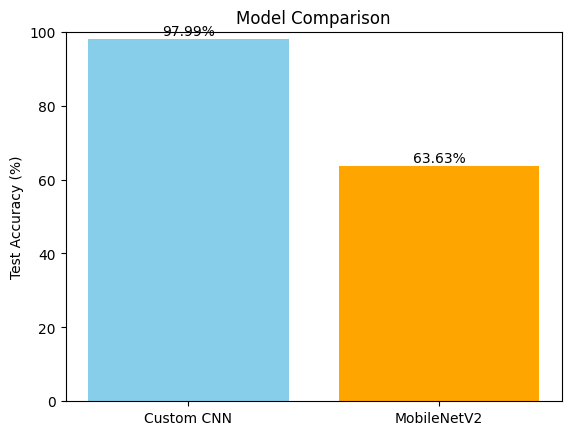

In [23]:
# --- Compare Saved Custom CNN vs Pre-trained MobileNetV2 (same X_test evaluation) ---
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Load saved Custom CNN
custom_model = load_model("gtsrb_custom_cnn.keras")
custom_pred_probs = custom_model.predict(X_test)
custom_pred = np.argmax(custom_pred_probs, axis=1)
custom_acc = np.mean(custom_pred == y_test)
print(f"Custom CNN (Loaded) Test Accuracy: {custom_acc*100:.2f}%")

# 2️⃣ Pre-trained MobileNetV2
num_classes = len(np.unique(y_train))  # <-- FIX

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(num_classes, activation='softmax')(x)
mobilenet_model = Model(inputs=base_model.input, outputs=predictions)

mobilenet_model.compile(optimizer=optimizers.Adam(1e-4),
                        loss='sparse_categorical_crossentropy',
                        metrics=['accuracy'])

# Train MobileNetV2
history_mobilenet = mobilenet_model.fit(X_train, y_train,
                                        validation_data=(X_val, y_val),
                                        epochs=10,
                                        batch_size=32,
                                        verbose=1)

mobilenet_pred_probs = mobilenet_model.predict(X_test)
mobilenet_pred = np.argmax(mobilenet_pred_probs, axis=1)
mobilenet_acc = np.mean(mobilenet_pred == y_test)
print(f"MobileNetV2 Test Accuracy: {mobilenet_acc*100:.2f}%")

# 3️⃣ Bar chart comparison
models = ['Custom CNN', 'MobileNetV2']
accuracies = [custom_acc*100, mobilenet_acc*100]

plt.bar(models, accuracies, color=['skyblue', 'orange'])
plt.ylabel('Test Accuracy (%)')
plt.title('Model Comparison')
plt.ylim(0, 100)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 1, f"{acc:.2f}%", ha='center')
plt.show()
